In [1]:
! pip install python-Levenshtein
! pip install editdistance

In [2]:
import json
import pandas as pd
import numpy as np
import random
import editdistance
from ast import literal_eval


In [3]:
# load files
with open('../data/trace_predictions_BPI_Challenge_2017.json', 'r') as f:
    predicted_traces = json.load(f)

with open('../data/traces_BPI_Challenge_2017.json', 'r') as f:
    actual_traces = json.load(f)

In [4]:
# for matching 1000 'case:concept:name'
matched_traces = []

for pred_trace in predicted_traces:
    case_name = pred_trace['case:concept:name']
    actual_trace = next(
        (trace for trace in actual_traces if trace['case:concept:name'] == case_name), None)
    if actual_trace:
        matched_traces.append({
            'case:concept:name': case_name,
            'predicted_traces': pred_trace['predicted_traces'],
            'trace': actual_trace['trace']
        })

In [5]:
results_df = pd.DataFrame(matched_traces)
results_df.to_csv(
    '../data/matched_traces.csv', index=False)

In [6]:
df = pd.read_csv(
    '../data/matched_traces.csv')

In [7]:
print(df.head(5))

       case:concept:name                                   predicted_traces  \
0  Application_939104505  [{'concept:name': 'A_Create Application', 'tim...   
1  Application_939229827  [{'concept:name': 'A_Create Application', 'tim...   
2   Application_93924041  [{'concept:name': 'A_Create Application', 'tim...   
3  Application_939246776  [{'concept:name': 'A_Create Application', 'tim...   
4  Application_939316996  [{'concept:name': 'A_Create Application', 'tim...   

                                               trace  
0  [{'concept:name': 'A_Create Application', 'tim...  
1  [{'concept:name': 'A_Create Application', 'tim...  
2  [{'concept:name': 'A_Create Application', 'tim...  
3  [{'concept:name': 'A_Create Application', 'tim...  
4  [{'concept:name': 'A_Create Application', 'tim...  


In [8]:
def extract_events(trace_list):
    try:
        trace_list_evaluated = literal_eval(
            trace_list) if isinstance(trace_list, str) else trace_list
        return [event['concept:name'] for event in trace_list_evaluated]
    except (ValueError, SyntaxError):
        # In case of any error during conversion, return an empty list or handle as needed
        print(f"Error processing trace: {trace_list}")
        return []


# Function to calculate the Jaccard Similarity for two sets
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

In [9]:
# Initialize lists to hold the metrics for each trace pair, Initialize a dictionary to hold the Edit Distances and case identifiers
edit_distances = []
jaccard_similarities = []
case_edit_distances = {}

# Loop through each row and calculate metrics
for _, row in df.iterrows():
    predicted_events = extract_events(row['predicted_traces'])
    actual_events = extract_events(row['trace'])

    # Calculate the edit distance for this pair of traces
    distance = editdistance.eval(predicted_events, actual_events)
    edit_distances.append(distance)
    # Add the distance with the case identifier to the dictionary
    case_edit_distances[row['case:concept:name']] = distance
    # Calculate the Jaccard similarity for this pair of traces
    similarity = jaccard_similarity(set(predicted_events), set(actual_events))
    jaccard_similarities.append(similarity)

In [10]:
# Calculate the mean of the edit distances and Jaccard similarities
mean_edit_distance = np.mean(edit_distances)
mean_jaccard_similarity = np.mean(jaccard_similarities)

# Find the case with the minimum Edit Distance
min_distance_case = min(case_edit_distances, key=case_edit_distances.get)
min_distance = case_edit_distances[min_distance_case]
print(f"Minimum Edit Distance: {min_distance} for case: {min_distance_case}")

# Print the list of edit distances for each pair of traces
print("List of Edit Distances for each pair of traces:")
print(edit_distances)

# Print the list of Jaccard similarities for each pair of traces
print(" \nList of Jaccard Similarities for each pair of traces:")
print(jaccard_similarities)

# Print the mean edit distance for the entire dataset
print(f" Mean Edit Distance for the entire dataset: {mean_edit_distance}")

# Print the mean Jaccard similarity for the entire dataset
print(f" Mean Jaccard Similarity for the entire dataset: {mean_jaccard_similarity}")

Minimum Edit Distance: 12 for case: Application_988180886
List of Edit Distances for each pair of traces:
[75, 59, 76, 72, 58, 77, 72, 75, 75, 76, 78, 71, 74, 66, 67, 74, 70, 64, 69, 40, 48, 78, 65, 75, 65, 60, 71, 71, 76, 64, 58, 78, 71, 63, 76, 77, 77, 75, 77, 67, 75, 70, 77, 73, 72, 65, 73, 72, 55, 63, 53, 57, 67, 74, 75, 73, 77, 48, 66, 78, 76, 63, 74, 75, 68, 67, 70, 76, 73, 73, 74, 74, 78, 69, 62, 77, 75, 73, 78, 46, 70, 75, 74, 74, 58, 74, 72, 55, 76, 70, 75, 74, 75, 76, 66, 63, 75, 77, 67, 76, 51, 75, 77, 61, 78, 72, 71, 72, 72, 76, 70, 70, 73, 61, 75, 72, 77, 66, 58, 74, 64, 71, 62, 73, 67, 65, 72, 86, 73, 62, 75, 72, 72, 77, 77, 74, 75, 71, 64, 58, 59, 77, 61, 73, 77, 68, 57, 66, 70, 66, 71, 57, 73, 67, 63, 76, 72, 70, 75, 54, 68, 77, 77, 76, 74, 74, 72, 64, 78, 71, 75, 56, 69, 78, 76, 70, 61, 78, 57, 71, 62, 72, 65, 68, 73, 79, 73, 59, 75, 55, 78, 74, 74, 73, 46, 38, 56, 70, 56, 62, 54, 60, 74, 49, 69, 73, 70, 59, 72, 74, 73, 77, 75, 42, 76, 70, 78, 69, 52, 73, 66, 77, 62, 7

In [12]:
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import plotly.graph_objects as go
import seaborn as sns


# Assuming the DataFrame is loaded from a CSV file:
df = pd.read_csv('../data/matched_traces.csv',
                 converters={'predicted_traces': literal_eval, 'trace': literal_eval})

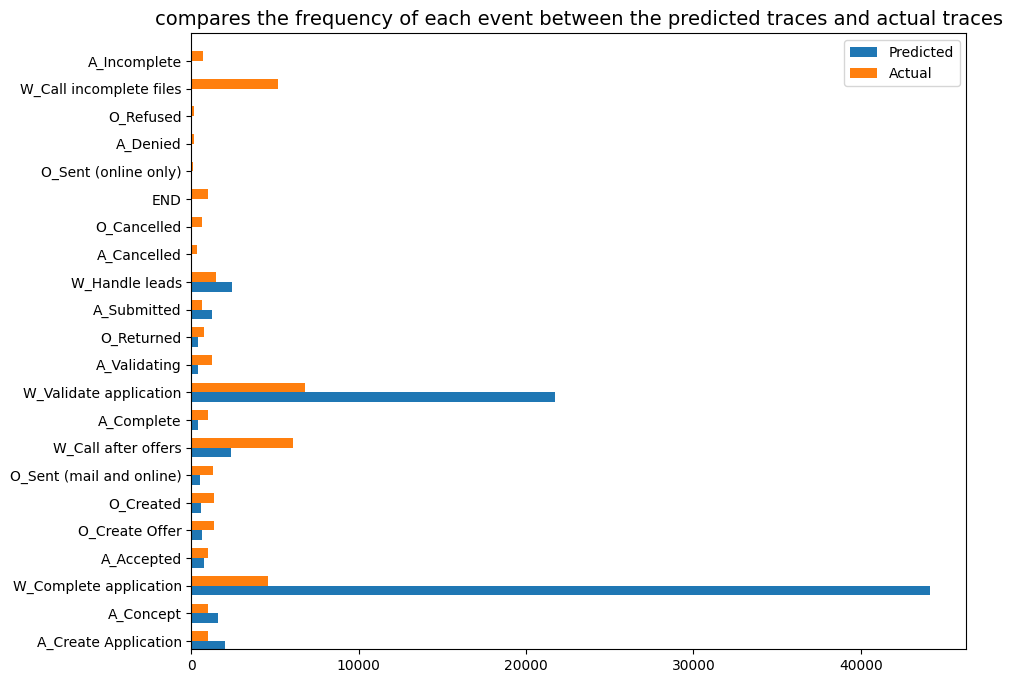

In [13]:
# Define a function to extract events from the serialized lists
def extract_events(serialized_list):
    return [event['concept:name'] for event in serialized_list]


# Apply this function to your columns to create the 'predicted_events' and 'actual_events' columns
df['predicted_events'] = df['predicted_traces'].apply(extract_events)
df['actual_events'] = df['trace'].apply(extract_events)

# Flatten the lists to count the frequency of each event
predicted_flattened = [
    event for sublist in df['predicted_events'] for event in sublist]
actual_flattened = [event for sublist in df['actual_events']
                    for event in sublist]

predicted_counts = Counter(predicted_flattened)
actual_counts = Counter(actual_flattened)

# Convert counters to dataframes
predicted_df = pd.DataFrame(predicted_counts.items(), columns=[
                            'Event', 'Predicted Frequency'])
actual_df = pd.DataFrame(actual_counts.items(), columns=[
                         'Event', 'Actual Frequency'])

# Merge on Event
merged_df = pd.merge(predicted_df, actual_df, on='Event')

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
width = 0.35  # bar width
ind = np.arange(len(merged_df))  # the x locations for the groups

ax.barh(ind - width/2,
        merged_df['Predicted Frequency'], width, label='Predicted')
ax.barh(ind + width/2, merged_df['Actual Frequency'], width, label='Actual')

ax.set(yticks=ind, yticklabels=merged_df['Event'], ylim=[
       2*width - 1, len(merged_df)])
ax.legend()
plt.title("compares the frequency of each event between the predicted traces and actual traces", fontsize=14)
plt.show()

# Over forecast (predicted bars are longer than they actually are) and under forecast (predicted bars are shorter than they actually are)

In [14]:
def create_sankey_df(events_list):
    source, target, value = [], [], []
    for trace in events_list:
        for i in range(len(trace)-1):
            if (trace[i], trace[i+1]) not in list(zip(source, target)):
                source.append(trace[i])
                target.append(trace[i+1])
                value.append(1)
            else:
                idx = list(zip(source, target)).index((trace[i], trace[i+1]))
                value[idx] += 1
    return pd.DataFrame({'source': source, 'target': target, 'value': value})


# Create DataFrames for predicted and actual events
predicted_sankey = create_sankey_df(df['predicted_events'])
actual_sankey = create_sankey_df(df['actual_events'])

# Generate a list of all unique events
all_events = list(set(predicted_sankey['source'].tolist() + predicted_sankey['target'].tolist(
) + actual_sankey['source'].tolist() + actual_sankey['target'].tolist()))
event_dict = {event: i for i, event in enumerate(all_events)}

# Map events to integers
predicted_sankey.replace(event_dict, inplace=True)
actual_sankey.replace(event_dict, inplace=True)

# Plot
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_events,
    ),
    link=dict(
        source=predicted_sankey['source'],
        target=predicted_sankey['target'],
        value=predicted_sankey['value'],
        color="blue"
    ))])

fig.update_layout(title_text="Predicted Trace Flows", font_size=10)
fig.show()

/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_90739/560859013.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predicted_sankey.replace(event_dict, inplace=True)
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_90739/560859013.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  actual_sankey.replace(event_dict, inplace=True)


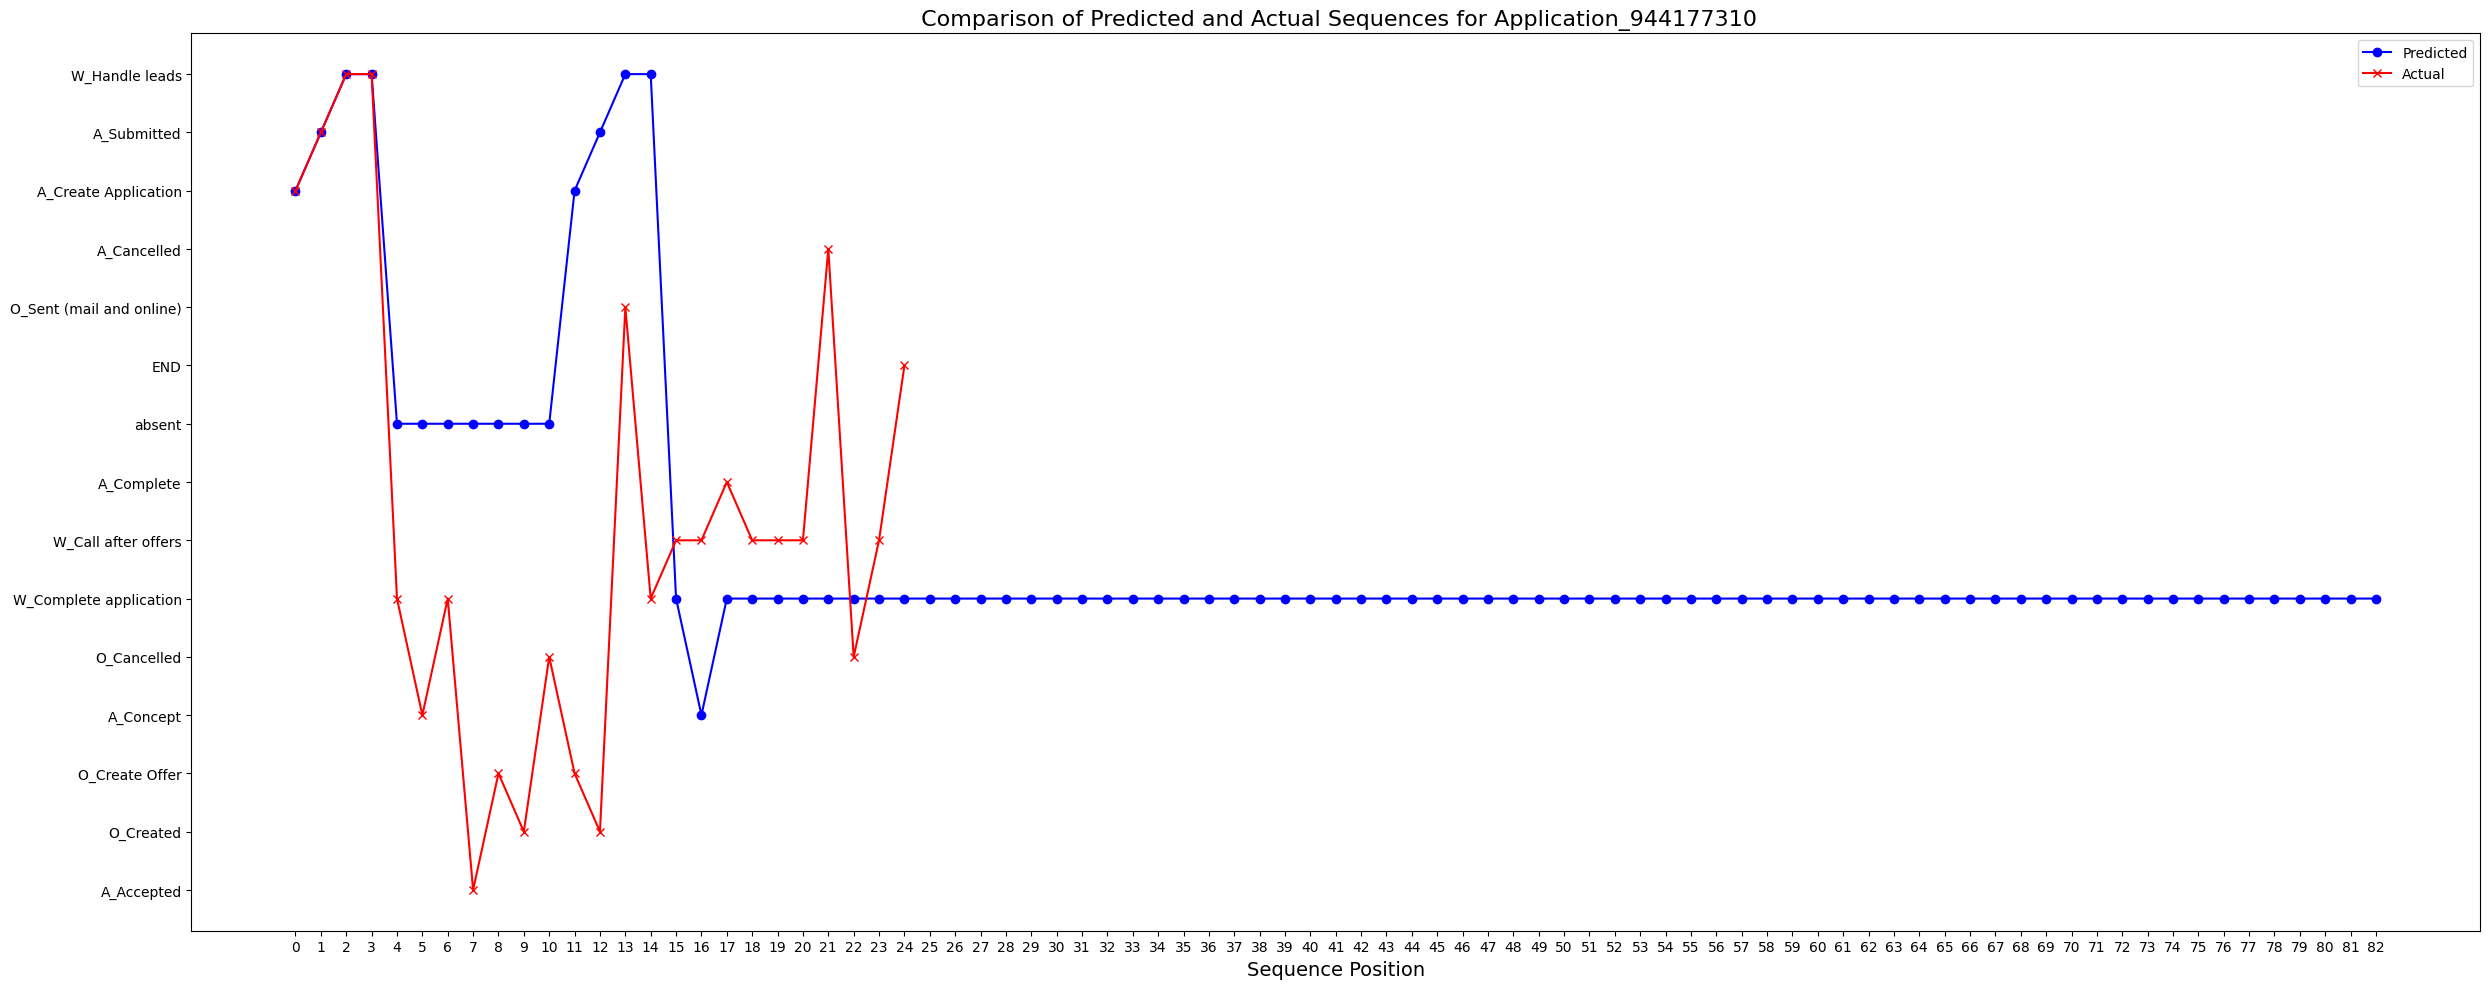

In [15]:
# Function to safely parse JSON content
def safely_parse_json(data):
    if isinstance(data, str):
        try:
            return json.loads(data)
        except ValueError as e:
            print(f"Error parsing JSON: {e}")
            return None  # or {}, [] depending on expected data type
    return data


# Apply the function to parse JSON for both columns if they're not already parsed
df['predicted_traces'] = df['predicted_traces'].apply(safely_parse_json)
df['trace'] = df['trace'].apply(safely_parse_json)

# Randomly select a trace
selected_index = random.randint(0, len(df) - 1)
selected_trace = df.iloc[selected_index]

# Extract the case name
case_name = selected_trace['case:concept:name']

# Extract and prepare data for plotting
predicted_events = [event['concept:name']
                    for event in selected_trace['predicted_traces']]
actual_events = [event['concept:name'] for event in selected_trace['trace']]
# Create mappings for events to integers
all_events = set(predicted_events + actual_events)
event_to_int = {event: i for i, event in enumerate(all_events)}

# Convert events to integers for plotting
mapped_pred_seq = [event_to_int[event] for event in predicted_events]
mapped_act_seq = [event_to_int[event] for event in actual_events]

# Generate the plot
fig, ax = plt.subplots(figsize=(25, 10))

# Plotting both predicted and actual sequences
ax.plot(mapped_pred_seq, 'o-', label='Predicted', color='blue')
ax.plot(mapped_act_seq, 'x-', label='Actual', color='red')

# Set the ticks and labels
ax.set_yticks(list(event_to_int.values()))
ax.set_yticklabels(list(event_to_int.keys()))
ax.legend()

plt.xlabel('Sequence Position', fontsize=14)
plt.xticks(np.arange(max(len(predicted_events), len(actual_events))))
plt.title(f' Comparison of Predicted and Actual Sequences for {case_name}', fontsize=16)
plt.tight_layout()
plt.show()

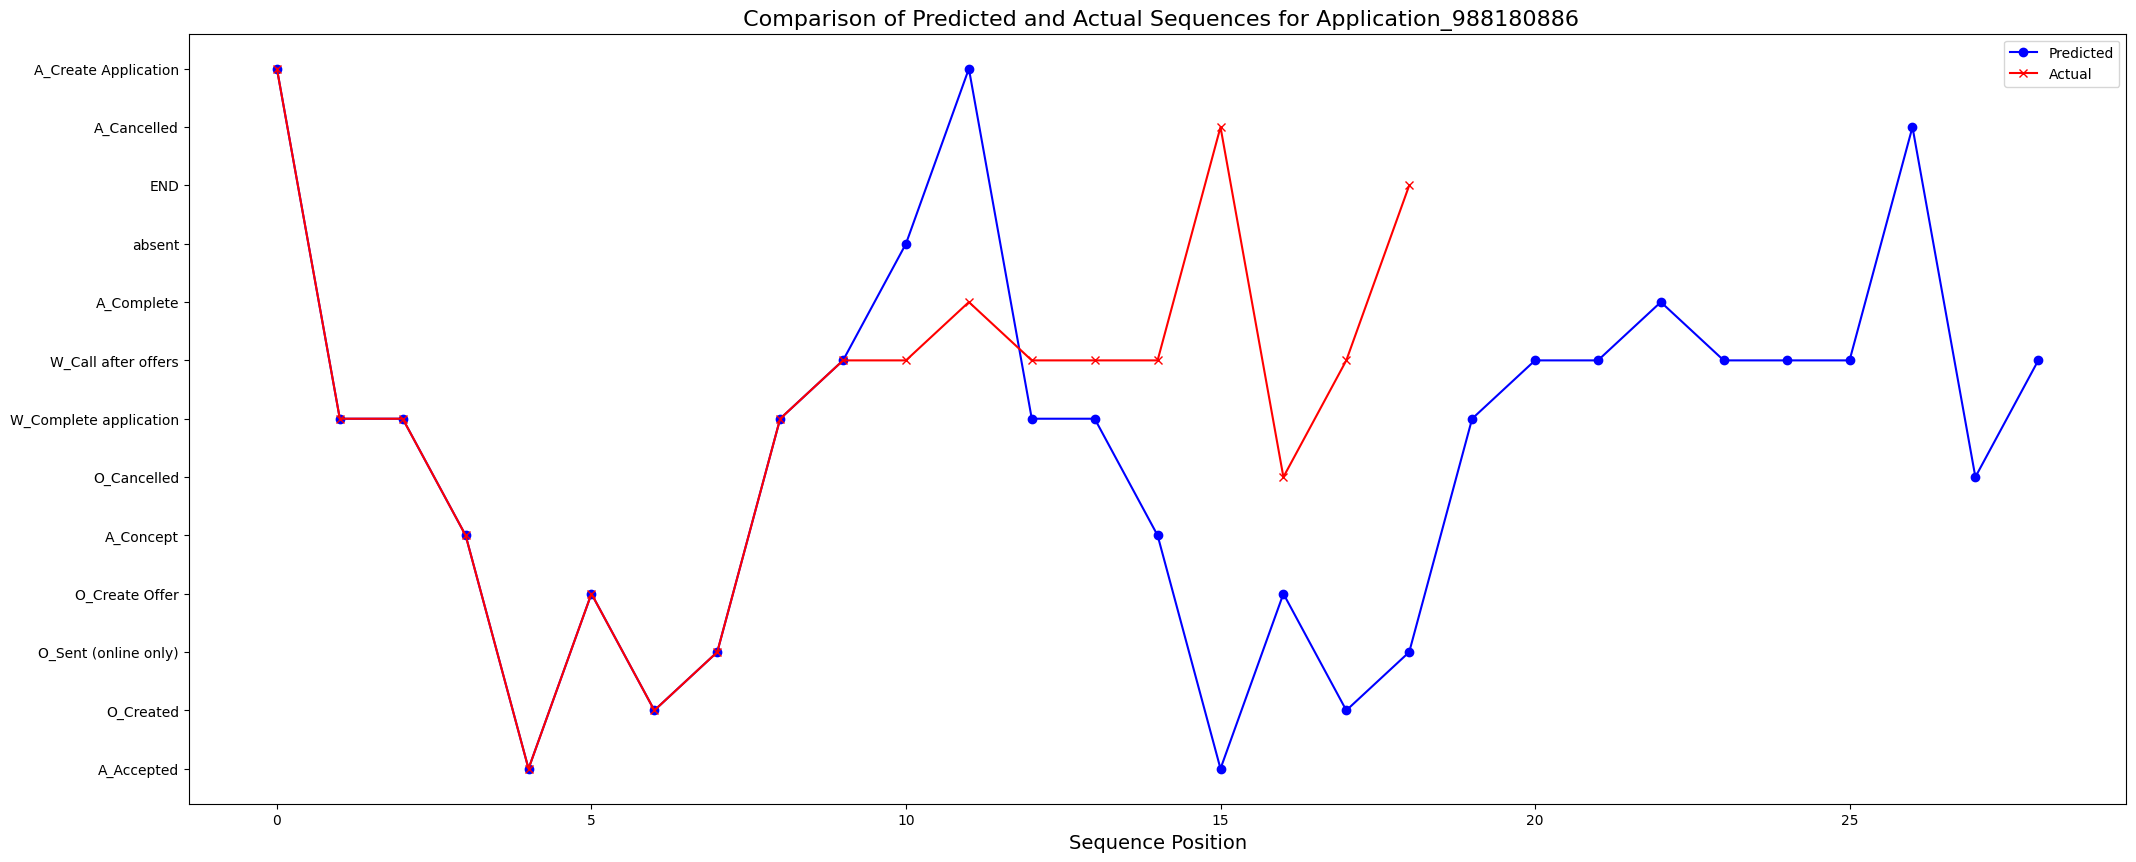

In [16]:
# Find the corresponding row for the case with the minimum Edit Distance
min_distance_row = df[df['case:concept:name'] == min_distance_case].iloc[0]

# Extract events for the minimum Edit Distance case
min_predicted_events = extract_events(min_distance_row['predicted_traces'])
min_actual_events = extract_events(min_distance_row['trace'])

# Now you can generate a comparison plot for the selected case
fig, ax = plt.subplots(figsize=(25, 10))

# Defining a simple mapping from event names to integers
event_set = set(min_predicted_events + min_actual_events)
event_map = {event: i for i, event in enumerate(event_set)}

# Mapping events to integers for plotting
mapped_min_pred_seq = [event_map[event] for event in min_predicted_events]
mapped_min_act_seq = [event_map[event] for event in min_actual_events]

# Plotting both predicted and actual sequences for the case with minimum Edit Distance
ax.plot(mapped_min_pred_seq, marker='o',
        label='Predicted', linestyle='-', color='blue')
ax.plot(mapped_min_act_seq, marker='x',
        label='Actual', linestyle='-', color='red')

ax.set_yticks(np.arange(len(event_set)))
ax.set_yticklabels(event_map.keys())
ax.legend()

plt.xlabel('Sequence Position', fontsize=14)
plt.title(f' Comparison of Predicted and Actual Sequences for {min_distance_case}', fontsize=16)
plt.show()

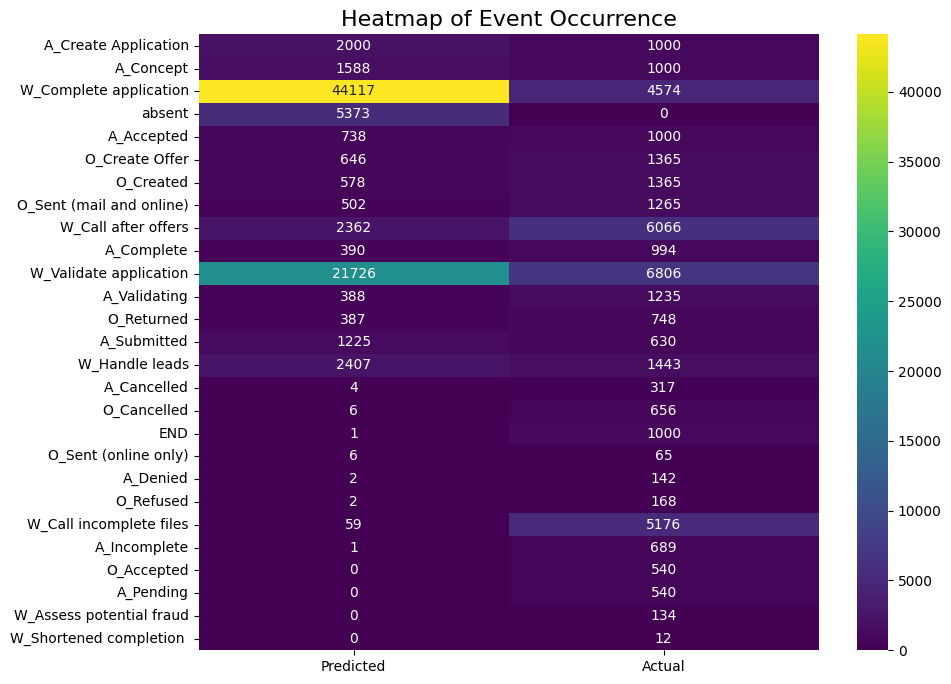

In [17]:
# Flatten the list of events for all sequences
all_pred_events = [event for sublist in df['predicted_events']
                   for event in sublist]
all_act_events = [event for sublist in df['actual_events']
                  for event in sublist]

pred_counts = Counter(all_pred_events)
act_counts = Counter(all_act_events)

# Creating a DataFrame from the counters
event_df = pd.DataFrame({
    'Predicted': pred_counts,
    'Actual': act_counts
})

# Filling NaN values with zeros since they represent no occurrence
event_df = event_df.fillna(0)

# Creating the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(event_df, annot=True, fmt='.0f', cmap='viridis')
plt.title('Heatmap of Event Occurrence', fontsize=16)
plt.show()
# Assess whether events are overestimated, underestimated, or closely match actual counts

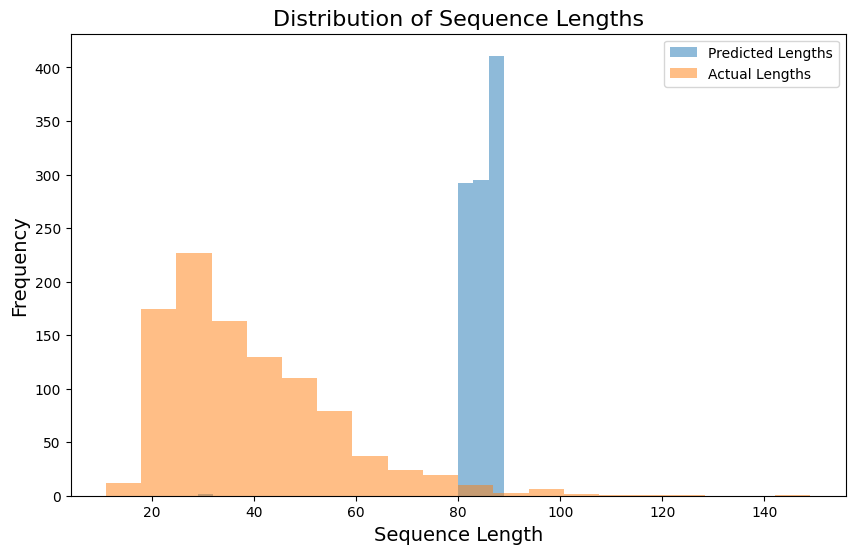

In [18]:
pred_lengths = df['predicted_events'].apply(len)
act_lengths = df['actual_events'].apply(len)

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(pred_lengths, bins=20, alpha=0.5, label='Predicted Lengths')
plt.hist(act_lengths, bins=20, alpha=0.5, label='Actual Lengths')
plt.xlabel('Sequence Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Sequence Lengths', fontsize=16)
plt.legend()

# If there are bars that extend far to the right, these bars may represent unusually long sequences of outliers
# significant differences between the distribution of predicted and actual sequence lengths. The predicted sequence appears to cluster around a specific length, while the actual sequence shows a different pattern, indicating that the actual sequence length varies more

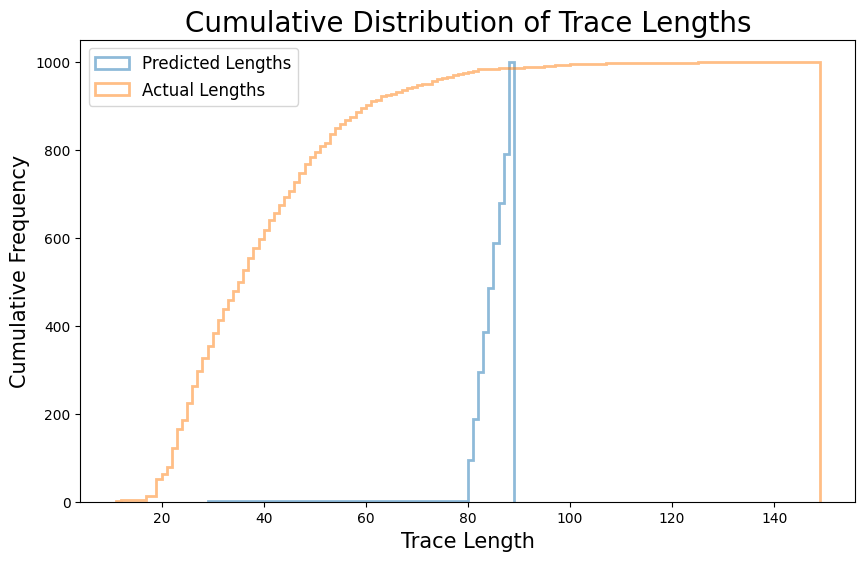

In [19]:
pred_lengths = df['predicted_events'].apply(len)
act_lengths = df['actual_events'].apply(len)

# Plot the cumulative distribution
plt.figure(figsize=(10, 6))
plt.hist(pred_lengths, bins=range(min(pred_lengths), max(pred_lengths) + 1),
         alpha=0.5, label='Predicted Lengths', cumulative=True, histtype='step', linewidth=2)
plt.hist(act_lengths, bins=range(min(act_lengths), max(act_lengths) + 1),
         alpha=0.5, label='Actual Lengths', cumulative=True, histtype='step', linewidth=2)
plt.xlabel('Trace Length', fontsize=15)
plt.ylabel('Cumulative Frequency', fontsize=15)
plt.title('Cumulative Distribution of Trace Lengths', fontsize=20)
plt.legend(fontsize=12)
plt.show()

In [20]:
# Extract events and timestamps from the 'predicted_traces' and 'trace' columns
df['predicted_events'] = df['predicted_traces'].apply(
    lambda x: [event['concept:name'] for event in x])
df['actual_events'] = df['trace'].apply(
    lambda x: [event['concept:name'] for event in x])
df['predicted_timestamps'] = df['predicted_traces'].apply(
    lambda x: [event['time:timestamp'] for event in x])
df['actual_timestamps'] = df['trace'].apply(
    lambda x: [event['time:timestamp'] for event in x])

['A_Create Application', 'A_Concept', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'absent', 'A_Create Application', 'A_Concept', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'W_Complete application', 'W_Co

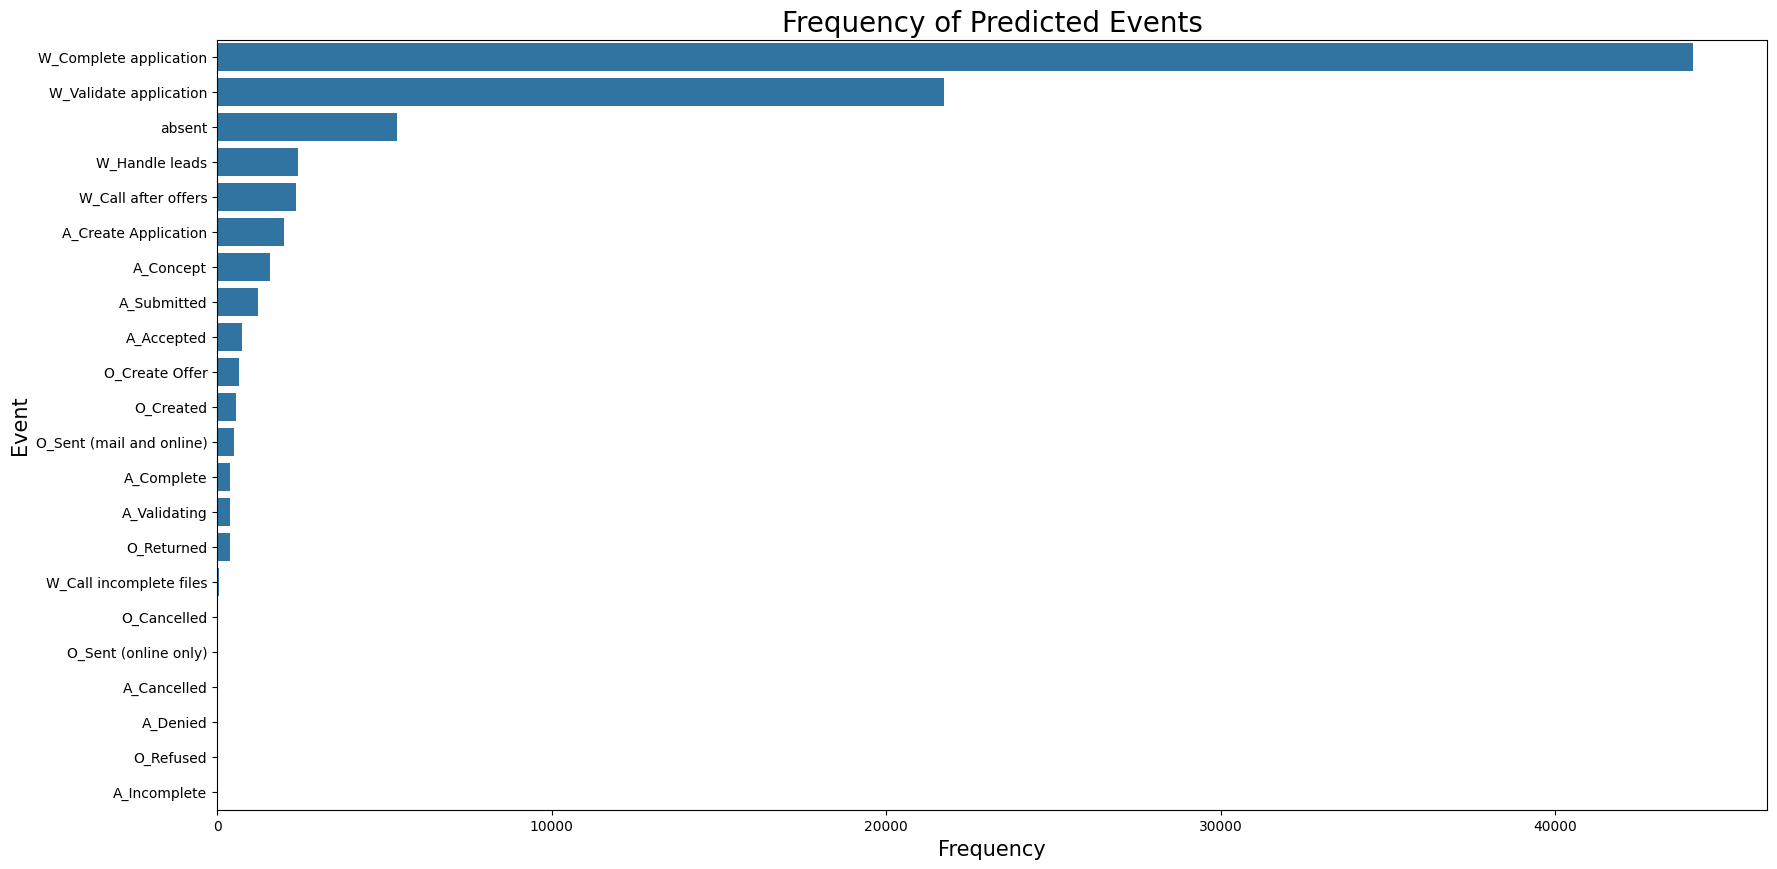

In [27]:
# Count the frequency of each predicted event
all_predicted_events = [
    event for sublist in df['predicted_events'].tolist() for event in sublist
]
print(all_predicted_events)
event_counter = Counter(all_predicted_events)

# Create a DataFrame from the counter
event_freq_df = pd.DataFrame(
    list(event_counter.items()), columns=['Event', 'Frequency'])

event_freq_df = event_freq_df[event_freq_df['Event'] != 'END']

# Plot the frequency of events as a bar chart
plt.figure(figsize=(20, 10))
sns.barplot(x='Frequency', y='Event', data=event_freq_df.sort_values(
    'Frequency', ascending=False))
plt.title('Frequency of Predicted Events', fontsize=20)
plt.xlabel('Frequency', fontsize=15)
plt.ylabel('Event', fontsize=15)
plt.show()